# TIMESERIES ANALYSIS

- ## IMPORT THE NECESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import combinations

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
pd.options.display.float_format = '{:.2f}'.format

In [2]:
data = pd.read_csv('sales.csv')
data = data.drop(columns = 'Unnamed: 0')
data.head()

,DATE,QUANTITY
0,2018-02-05 07:38:25.430,7
1,2018-02-02 16:03:31.150,7
2,2018-05-03 19:31:56.880,24
3,2018-04-07 14:43:55.420,19
4,2018-02-12 15:37:03.940,9


- ## CHECK FOR NAN VALUES IN THE DATA AND CONVERT THE DATE COLUMN TO DATETIME

In [3]:
data['DATE'] = pd.to_datetime(data['DATE'])
data['DATE'] = [data.date() for data in data['DATE']]
data['DATE'] = pd.to_datetime(data['DATE'])
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6758125 entries, 0 to 6758124
Data columns (total 2 columns):
 #   Column    Dtype         
---  ------    -----         
 0   DATE      datetime64[ns]
 1   QUANTITY  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 103.1 MB
None


,DATE,QUANTITY
0,2018-02-05,7
1,2018-02-02,7
2,2018-05-03,24
3,2018-04-07,19
4,2018-02-12,9


- ## ASSIGN THIS DATE COLUMN AS THE INDEX OF THE DATAFRAME 

In [4]:
data = data.set_index('DATE')
data = data.groupby(data.index).mean()
data.head()

,QUANTITY
DATE,
2018-01-01,13.02
2018-01-02,12.97
2018-01-03,13.07
2018-01-04,12.99
2018-01-05,13.03


## FUNCTIONS FOR TIMESERIES

In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [6]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

# PLOT THE DATA

## 1] DATA

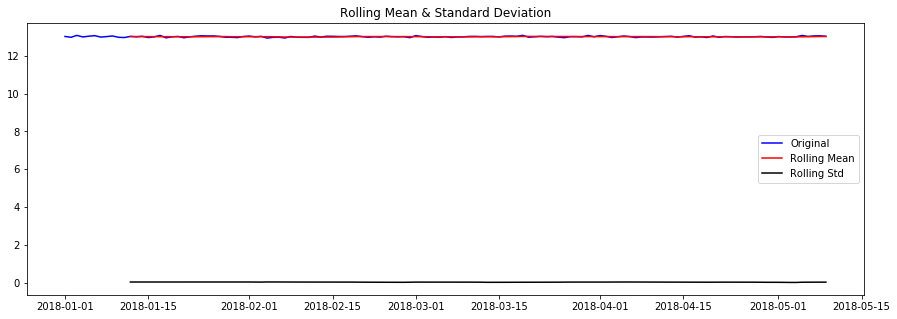

Results of Dickey-Fuller Test:
Test Statistic                -10.82
p-value                         0.00
#Lags Used                      0.00
Number of Observations Used   128.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [7]:
test_stationarity(data['QUANTITY'])

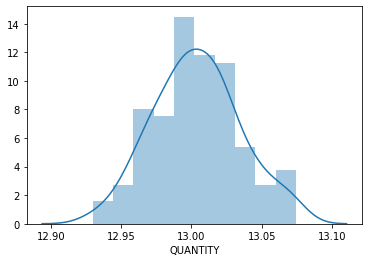

In [8]:
sns.distplot(data['QUANTITY'])

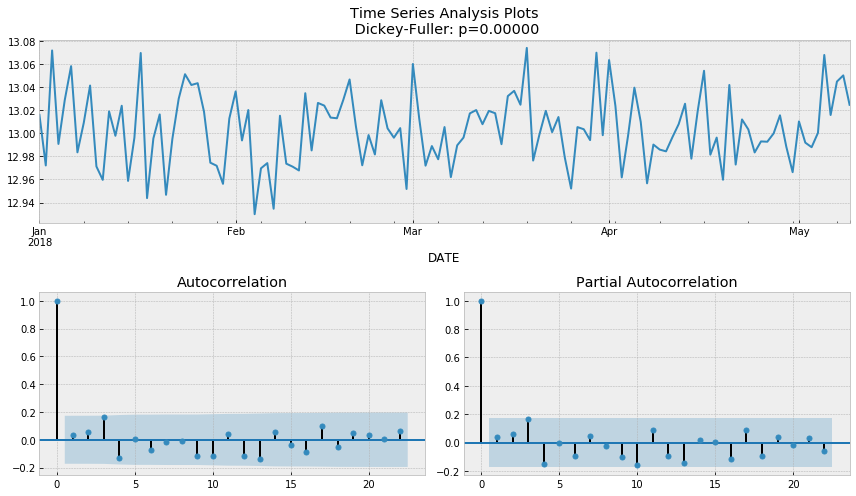

In [9]:
tsplot(data['QUANTITY'])

- ### HERE ACCORDING TO THE DICKEY FULLER TEST, THE DATA IS STATIONARY
- ### WE NOW NEED TO CHECK FOR TREND AND SEASONALITY PRESENT IN THE DATA

## DECOMPOSITION 

### 1] DATA

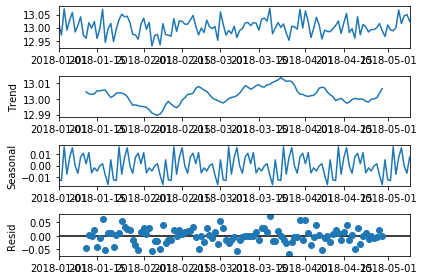

In [10]:
dec = sm.tsa.seasonal_decompose(data,period = 20).plot()
plt.show()

- ### THERE IS AN UNEVEN TREND THROUGHOUT THE DATA AND ALSO THE DATA IS SEASONAL

- ### TO SOLVE THIS ISSUE, WE USE THE METHOD OF DIFFERENCING

# DIFFERENCING

### 1] DATA

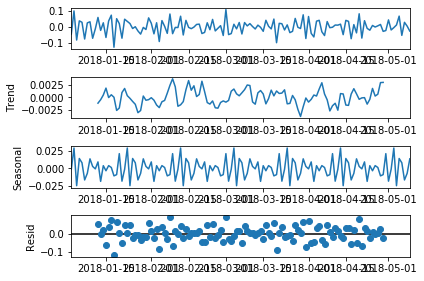

In [11]:
data_diff = data.diff()
data_diff = data_diff.dropna()
dec = sm.tsa.seasonal_decompose(data_diff,period = 20)
dec.plot()
plt.show()

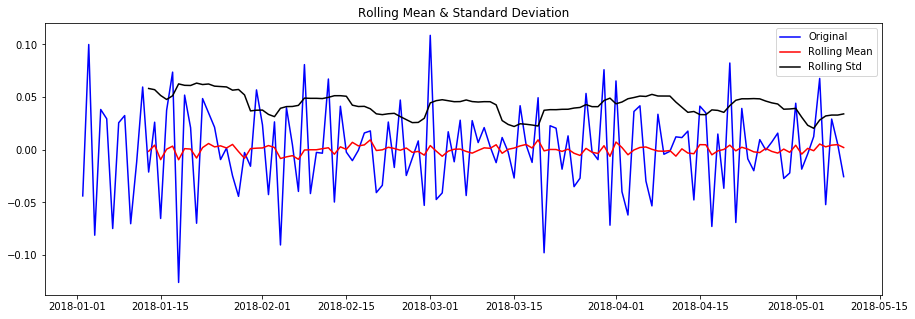

Results of Dickey-Fuller Test:
Test Statistic                 -7.32
p-value                         0.00
#Lags Used                      5.00
Number of Observations Used   122.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


In [12]:
test_stationarity(data_diff)

- ### AFTER DIFFERENCING, THE TREND IN THE DATA OSCILLATES AROUND 0 HOWEVER, SEASONLITY IS STILL PRESENT

## ARIMA

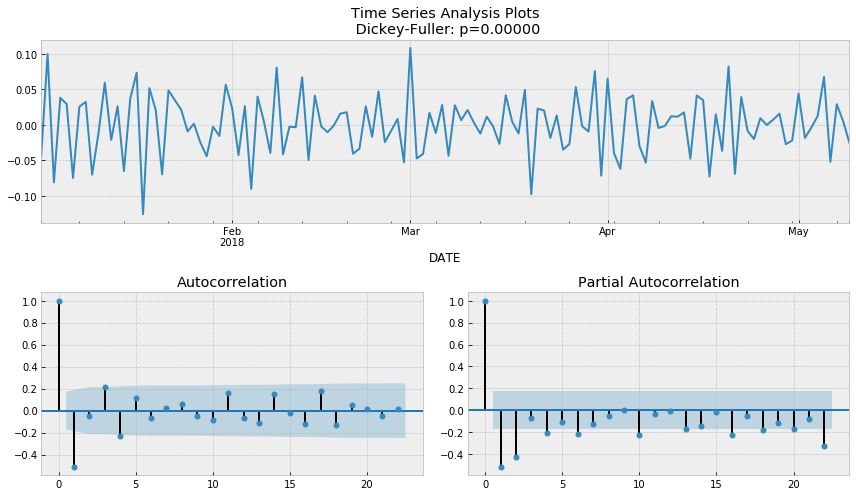

In [13]:
tsplot(data_diff['QUANTITY'])

## ARIMA[p,d,q]
- ### p = Autocorrelation plot --> The lag value[on x-axis] at which the line drawn from lag 0 cuts the confidence interval[blue part]
- ### d = Number of differencing
- ### q = Partial Autocorrelation plot --> The lag value[on x-axis] at which the line drawn from lag 0 cuts the confidence interval[blue part]

In [14]:
model = ARIMA(data['QUANTITY'],order = (0,1,1),freq = 'D')
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.QUANTITY   No. Observations:                  128
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 261.531
Method:                       css-mle   S.D. of innovations              0.031
Date:                Tue, 16 Jun 2020   AIC                           -517.061
Time:                        00:53:46   BIC                           -508.505
Sample:                    01-02-2018   HQIC                          -513.585
                         - 05-09-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.866e-05   7.28e-05      0.531      0.595      -0.000       0.000
ma.L1.D.QUANTITY    -1.0000      0.024    -42.314      0.000      -1.046      -0.954
                            

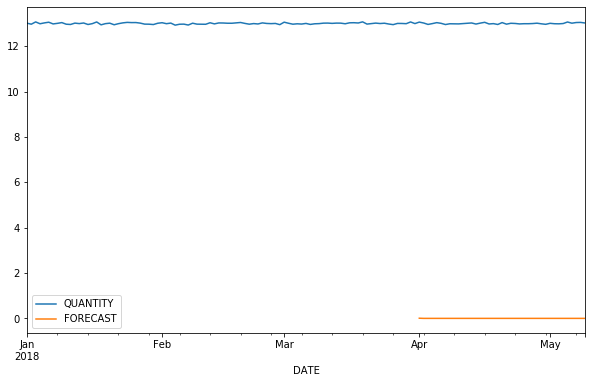

In [15]:
data['FORECAST'] = model_fit.predict(start = 90,end = 129,dynamic = True)
data[['QUANTITY','FORECAST']].plot(figsize = (10,6))

In [16]:
exp = [data.iloc[i,0] for i in range(90,len(data))]
pred = [data.iloc[i,1] for i in range(90,len(data))]
data = data.drop(columns = 'FORECAST')
error = mean_absolute_error(exp,pred)
error

13.004942433955206

- ## PREDICTIONS OF ARIMA ARE NOT GOOD BECAUSE WE DID CONSIDER THE SEASONAL PART OF OUR DATA

## SARIMAX

- ## SEASONAL DIFFERENCE

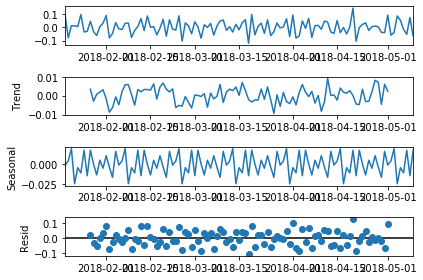

In [17]:
data_diff_seas = data_diff.diff(17)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 17).plot()
plt.show()

- ## NOW WE CARRY OUT THE DIFFERENCING OPERATION ON THE PREVIOUSLY DIFFERENCED DATA BY OUR SEASONAL FACTOR [s]
- ## s = 17

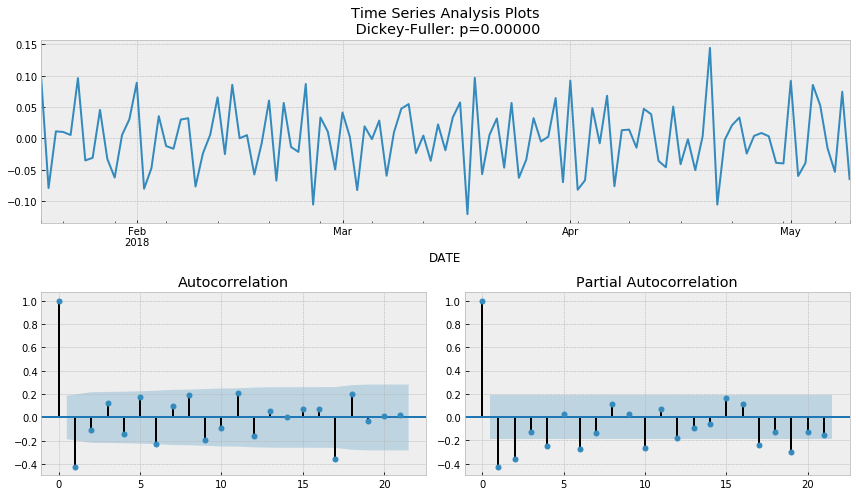

In [18]:
tsplot(data_diff_seas['QUANTITY'])

- ### PLOT THIS SEASONAL DIFFERENCED DATA AND GET THE VALUES OF THE SEASONAL ORDER OF THE SARIMA MODEL
- ### TECHNIQUE FOR FINDING THE SEASONAL ORDER[P,D,Q,s] IS SIMILAR TO FINDING THE ORDER OF ARIMA MODEL
- ### YOU CAN DO TRIAL & ERROR BY CHANGING THE SEASONAL ORDER AND SELECT THE ORDER WITH THE LEAST VALUE OF AIC

In [19]:
model = sm.tsa.statespace.SARIMAX(data['QUANTITY'],order = (0,1,1),seasonal_order = (0,1,0,17),freq = 'D')
results = model.fit()
print(results.summary())

E:\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                            QUANTITY   No. Observations:                  129
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 17)   Log Likelihood                 194.689
Date:                             Tue, 16 Jun 2020   AIC                           -385.379
Time:                                     00:54:27   BIC                           -379.960
Sample:                                 01-01-2018   HQIC                          -383.181
                                      - 05-09-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9923      0.114     -8.725      0.000      -1.215      -0.769
sigma2         0.0017      

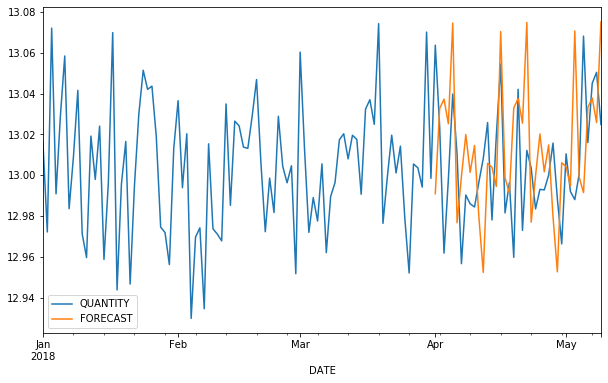

In [20]:
data['FORECAST'] = results.predict(start = 90,end = 129,dynamic = True)
data[['QUANTITY','FORECAST']].plot(figsize = (10,6))

In [21]:
exp = [data.iloc[i,0] for i in range(90,len(data))]
pred = [data.iloc[i,1] for i in range(90,len(data))]
error = mean_absolute_error(exp,pred)
error

0.03127361646831658

- ## NOW THE PREDICTION ERROR IS PRETTY LOW AND AROUND 0
- ## WE CAN NOW USE THIS FOR FORECASTING PURPOSES

# FORECASTING

- ### ADD DATES FOR FORECASTING PURPOSES AND PLOT THE FORECASTED VALUES

In [22]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(days = x)for x in range(0,31)]
df = pd.DataFrame(index = future_dates[1:],columns = data.columns)

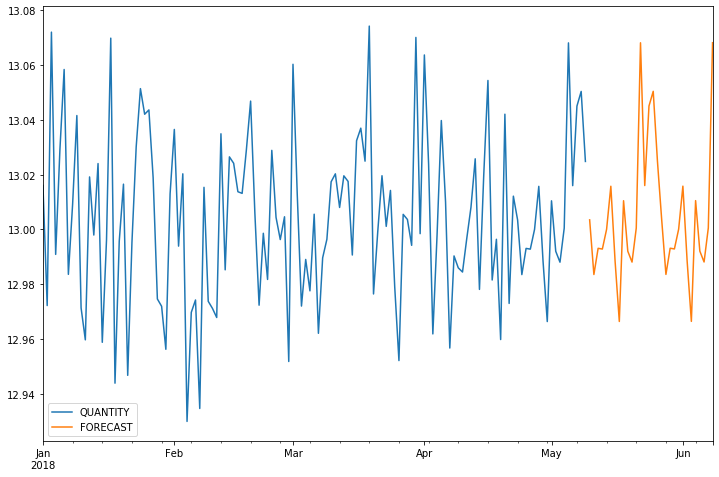

In [23]:
forecast = pd.concat([data,df])
forecast['FORECAST'] = results.predict(start = 129,end = 159,dynamic = True)
forecast[['QUANTITY','FORECAST']].plot(figsize = (12,8))

# END